In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [5]:

#dataset_path = '/content/drive/MyDrive/milan-dataset1.csv'

data = pd.read_csv(dataset_path, delimiter=',', header=None, names=['Date', 'Time', 'Interval', 'Sensor ID', 'State', 'Activity Label', 'Start/End'])

data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y', errors='coerce')


def preprocess_time_to_seconds(value):
    try:
        time_parts = value.split(':')
        minutes = int(time_parts[0])
        seconds = float(time_parts[1])
        total_seconds = minutes * 60 + seconds
        return total_seconds
    except (ValueError, IndexError):
        return np.nan  

data['Time_in_Seconds'] = data['Time'].apply(preprocess_time_to_seconds)


def preprocess_state(value):
    if value in ['ON', 'OPEN']:
        return 1.0
    elif value in ['OFF', 'CLOSE']:
        return 0.0
    else:
        try:
            return float(value)
        except ValueError:
            return np.nan

data['State'] = data['State'].apply(preprocess_state)
data['State'] = data['State'].fillna(0.0)


unique_sensor_codes = {}
def get_unique_sensor_code(sensor_id):
    if sensor_id not in unique_sensor_codes:
        unique_sensor_codes[sensor_id] = len(unique_sensor_codes) + 1
    return unique_sensor_codes[sensor_id]


data['Sensor_Unique_Code'] = data['Sensor ID'].apply(get_unique_sensor_code)

def preprocess_sensor_state(row):
    sensor_id = row['Sensor ID']
    state = row['State']
    if sensor_id.startswith('M'):
        return [state, 0.0, 0.0] 
    elif sensor_id.startswith('D'):
        return [0.0, state, 0.0] 
    elif sensor_id.startswith('T'):
        return [0.0, 0.0, float(state)]  
    return [0.0, 0.0, np.nan]  

data[['Sensor_Motion', 'Sensor_Door', 'Sensor_Temperature']] = pd.DataFrame(data.apply(preprocess_sensor_state, axis=1).tolist(), index=data.index)


data['Sensor_Temperature'] = data['Sensor_Temperature'].fillna(data['Sensor_Temperature'].median())
data['Activity Label'] = data['Activity Label'].fillna('No Activity')
data['Start/End'] = data['Start/End'].fillna('None')


if data.iloc[0]['Start/End'] != 'begin':
    data.at[0, 'Start/End'] = 'begin'


def preprocess_sensor_id(sensor_id):
    if sensor_id.startswith('M'):
        return 1.0  
    elif sensor_id.startswith('D'):
        return 2.0  
    elif sensor_id.startswith('T'):
        return 3.0 
    else:
        return 0.0  
data['Sensor Numeric ID'] = data['Sensor ID'].apply(preprocess_sensor_id)


scaler = MinMaxScaler()
data['State'] = scaler.fit_transform(data[['State']])


temperature_scaler = MinMaxScaler()
data['Sensor_Temperature'] = temperature_scaler.fit_transform(data[['Sensor_Temperature']])


time_scaler = MinMaxScaler()
data['Time_in_Seconds'] = time_scaler.fit_transform(data[['Time_in_Seconds']])


current_activity = 'No Activity'
for index, row in data.iterrows():
    if row['Start/End'] == 'begin':
        current_activity = row['Activity Label']
    elif row['Start/End'] == 'end':
        data.at[index, 'Activity Label'] = current_activity
        current_activity = 'No Activity'
    else:
        data.at[index, 'Activity Label'] = current_activity


data['Interval'] = pd.to_numeric(data['Interval'], errors='coerce')  
data['Interval'] = data['Interval'].fillna(data['Interval'].median())

scaler = MinMaxScaler()
data['Interval Normalized'] = scaler.fit_transform(data[['Interval']])

label_encoder = LabelEncoder()
data['Activity_Label_Encoded'] = label_encoder.fit_transform(data['Activity Label'])

data = data[['Date', 'Interval Normalized','Sensor ID', 'Sensor_Unique_Code', 'State', 'Activity_Label_Encoded', 'Start/End',
             'Sensor_Motion', 'Sensor_Door', 'Sensor_Temperature', 'Sensor Numeric ID',
             'Time_in_Seconds']]

sensor_unique_codes = data['Sensor_Unique_Code']
unique_sensor_count = sensor_unique_codes.nunique()
print("Unique Sensor Codes Count:", unique_sensor_count)


label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Label Mapping:", label_mapping)
print("Preprocessed Data Sample:")
print(data.head(5))
print("\nData Shape:", data.shape)


Unique Sensor Codes Count: 33
Label Mapping: {'Bed_to_Toilet': 0, 'Chores': 1, 'Desk_Activity': 2, 'Dining_Rm_Activity': 3, 'Eve_Meds': 4, 'Guest_Bathroom': 5, 'Kitchen_Activity': 6, 'Leave_Home': 7, 'Master_Bathroom': 8, 'Master_Bedroom_Activity': 9, 'Meditate': 10, 'Morning_Meds': 11, 'No Activity': 12, 'Read': 13, 'Sleep': 14, 'Watch_TV': 15}
Preprocessed Data Sample:
        Date  Interval Normalized Sensor ID  Sensor_Unique_Code     State  \
0 2009-10-16             0.591837      M017                   1  0.032787   
1 2009-10-16             0.459184      M009                   2  0.032787   
2 2009-10-16             0.642857      M017                   1  0.000000   
3 2009-10-16             0.816327      M019                   3  0.032787   
4 2009-10-16             0.275510      M009                   2  0.000000   

   Activity_Label_Encoded Start/End  Sensor_Motion  Sensor_Door  \
0                      12     begin            1.0          0.0   
1                      12    

In [6]:

features = ['Time_in_Seconds', 'Interval Normalized', 'Sensor_Unique_Code', 'Sensor_Motion',
            'Sensor_Door', 'Sensor_Temperature', 'Activity_Label_Encoded', 'State', 'Sensor Numeric ID']
data = data[features].copy()

window_size_seconds = 30
data['Time_Window'] = (data['Time_in_Seconds'] // window_size_seconds).astype(int)

data['Activity_Group'] = (data['Activity_Label_Encoded'] != data['Activity_Label_Encoded'].shift()).cumsum()

data['Combined_Group'] = data['Time_Window'].astype(str) + "_" + data['Activity_Group'].astype(str)

groups = {group: data for group, data in data.groupby('Combined_Group')}


initial_class_counts = data['Activity_Label_Encoded'].value_counts()
print("تعداد نمونه‌های اولیه کلاس‌ها:")
print(initial_class_counts)

target_class = 12
if target_class in initial_class_counts.index:
    class_12_data = data[data['Activity_Label_Encoded'] == target_class]
    non_class_12_data = data[data['Activity_Label_Encoded'] != target_class]

    frac = 0.05 
    class_12_data = class_12_data.sample(frac=frac, random_state=42)
    data = pd.concat([class_12_data, non_class_12_data])
else:
    print(f"کلاس {target_class} در داده‌ها یافت نشد.")

class_counts_after_downsampling = data['Activity_Label_Encoded'].value_counts()
print("تعداد نمونه‌های کلاس‌ها بعد از داون‌سمپلینگ:")
print(class_counts_after_downsampling)

sampling_strategy = {}

for cls, count in class_counts_after_downsampling.items():
    if count < 8000:
        sampling_strategy[cls] = 8000 
    else:
        sampling_strategy[cls] = count  

print(f"استراتژی SMOTE: {sampling_strategy}")

# اعمال SMOTE
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(
    data.drop(columns=['Activity_Label_Encoded', 'Combined_Group', 'Activity_Group', 'Time_Window']),
    data['Activity_Label_Encoded']
)


data_resampled_smote = pd.DataFrame(X_resampled, columns=data.drop(columns=['Activity_Label_Encoded', 'Combined_Group', 'Activity_Group', 'Time_Window']).columns)
data_resampled_smote['Activity_Label_Encoded'] = y_resampled


data_resampled_smote['Time_Window'] = (data_resampled_smote['Time_in_Seconds'] // window_size_seconds).astype(int)
data_resampled_smote['Activity_Group'] = (data_resampled_smote['Activity_Label_Encoded'] != data_resampled_smote['Activity_Label_Encoded'].shift()).cumsum()
data_resampled_smote['Combined_Group'] = data_resampled_smote['Time_Window'].astype(str) + "_" + data_resampled_smote['Activity_Group'].astype(str)

class_counts_after_smote = data_resampled_smote['Activity_Label_Encoded'].value_counts()
print("تعداد نمونه‌های کلاس‌ها بعد از SMOTE:")
print(class_counts_after_smote)

window = 30 
stride = 26  
features_size = len(features) - 1

x = []
y = []

for group_id, group_data in data_resampled_smote.groupby('Combined_Group'):
    c_data = group_data[group_data.columns.drop(['Activity_Label_Encoded', 'Combined_Group', 'Activity_Group', 'Time_Window'])].values
    label = group_data['Activity_Label_Encoded'].iloc[0]
    for start in range(0, len(c_data) - window + 1, stride):
        window_data = c_data[start:start + window]
        if len(window_data) == window:
            x.append(window_data)
            y.append(label)

x = np.array(x)
y = np.array(y)

print(f"تعداد نمونه‌ها: {len(x)}")
print(f"شکل x: {x.shape}")
print(f"اندازه y: {y.shape}")


تعداد نمونه‌های اولیه کلاس‌ها:
Activity_Label_Encoded
12    198748
6      92074
13     41418
14     20075
15     18453
8      15023
9      12848
5      10394
2       7628
1       5242
7       4946
3       3043
10      1315
0       1185
11      1023
4        250
Name: count, dtype: int64
تعداد نمونه‌های کلاس‌ها بعد از داون‌سمپلینگ:
Activity_Label_Encoded
6     92074
13    41418
14    20075
15    18453
8     15023
9     12848
5     10394
12     9937
2      7628
1      5242
7      4946
3      3043
10     1315
0      1185
11     1023
4       250
Name: count, dtype: int64
استراتژی SMOTE: {6: 92074, 13: 41418, 14: 20075, 15: 18453, 8: 15023, 9: 12848, 5: 10394, 12: 9937, 2: 8000, 1: 8000, 7: 8000, 3: 8000, 10: 8000, 0: 8000, 11: 8000, 4: 8000}
تعداد نمونه‌های کلاس‌ها بعد از SMOTE:
Activity_Label_Encoded
6     92074
13    41418
14    20075
15    18453
8     15023
9     12848
5     10394
12     9937
7      8000
1      8000
0      8000
11     8000
2      8000
4      8000
10     8000
3      8000

In [7]:

y = np.array(y).reshape(-1, 1)
total_size = y.shape[0]
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size 

X_train = x[:train_size, :, :]
y_train = y[:train_size, :]

X_val = x[train_size:train_size + val_size, :, :]
y_val = y[train_size:train_size + val_size, :]

X_test = x[train_size + val_size:, :, :]
y_test = y[train_size + val_size:, :]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (6721, 30, 8)
y_train shape: (6721, 1)
X_val shape: (960, 30, 8)
y_val shape: (960, 1)
X_test shape: (1921, 30, 8)
y_test shape: (1921, 1)


In [8]:

class ActivityDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = ActivityDataset(X_train, y_train)
val_dataset = ActivityDataset(X_val, y_val)
test_dataset = ActivityDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")


Training data shape: (6721, 30, 8)
Validation data shape: (960, 30, 8)
Test data shape: (1921, 30, 8)
Training labels shape: (6721, 1)
Validation labels shape: (960, 1)
Test labels shape: (1921, 1)


In [9]:

if torch.cuda.is_available():
    device = torch.device('cuda') 
    print("GPU with CUDA is available.")
else:
    device = torch.device('cpu') 
    print("Running on CPU.")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.squeeze(), dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.squeeze(), dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.squeeze(), dtype=torch.long)



GPU with CUDA is available.


Using device: cuda
Epoch [50/500] | Train Loss: 2.1762 | Val Loss: 1.9417
Epoch [100/500] | Train Loss: 1.7023 | Val Loss: 1.6127
Epoch [150/500] | Train Loss: 1.3635 | Val Loss: 1.3715
Epoch [200/500] | Train Loss: 1.1592 | Val Loss: 1.2392
Epoch [250/500] | Train Loss: 0.9999 | Val Loss: 1.1134
Epoch [300/500] | Train Loss: 0.8817 | Val Loss: 1.0036
Epoch [350/500] | Train Loss: 0.7929 | Val Loss: 0.9508
Epoch [400/500] | Train Loss: 0.7387 | Val Loss: 0.9155
Epoch [450/500] | Train Loss: 0.6953 | Val Loss: 0.8868
Epoch [500/500] | Train Loss: 0.6609 | Val Loss: 0.8691

--- Train Data ---
Accuracy : 79.47%
Precision: 79.12%
Recall   : 79.47%
F1 Score : 79.17%


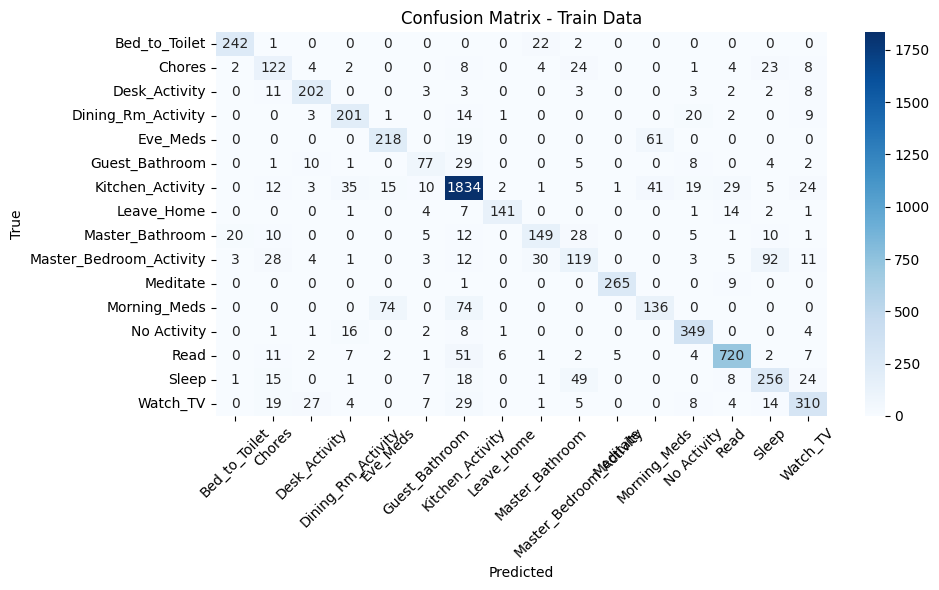


--- Validation Data ---
Accuracy : 74.58%
Precision: 74.53%
Recall   : 74.58%
F1 Score : 74.27%


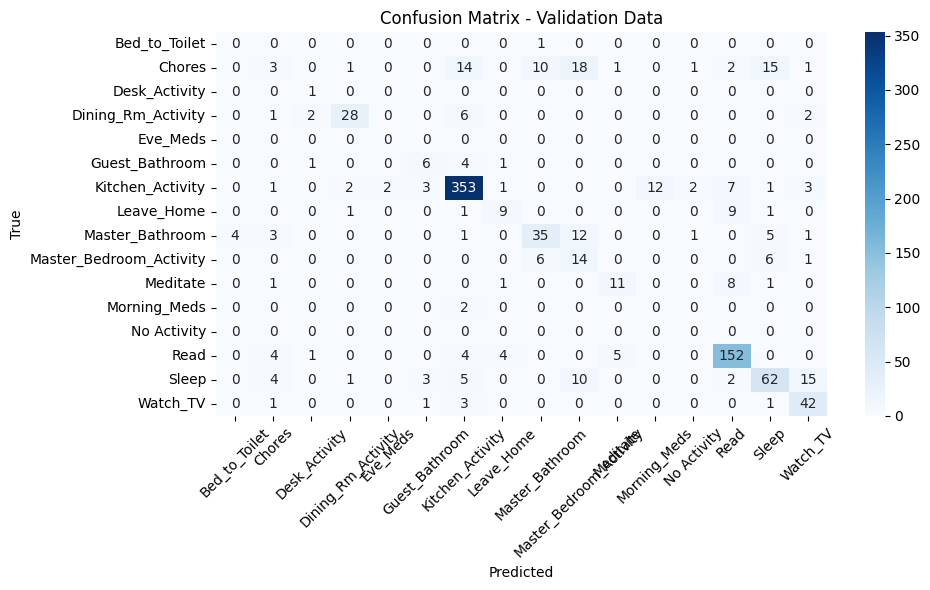


--- Test Data ---
Accuracy : 80.01%
Precision: 82.76%
Recall   : 80.01%
F1 Score : 81.26%


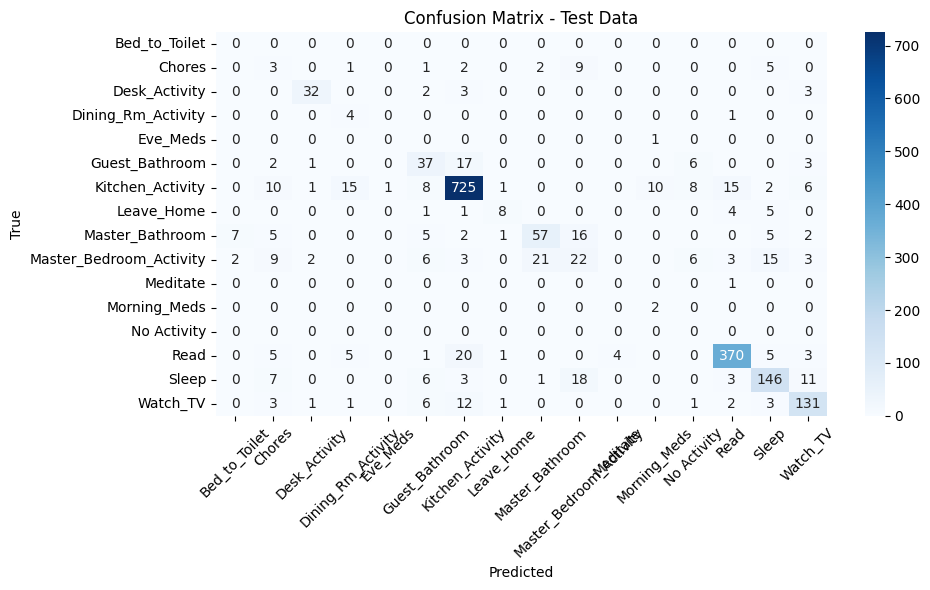

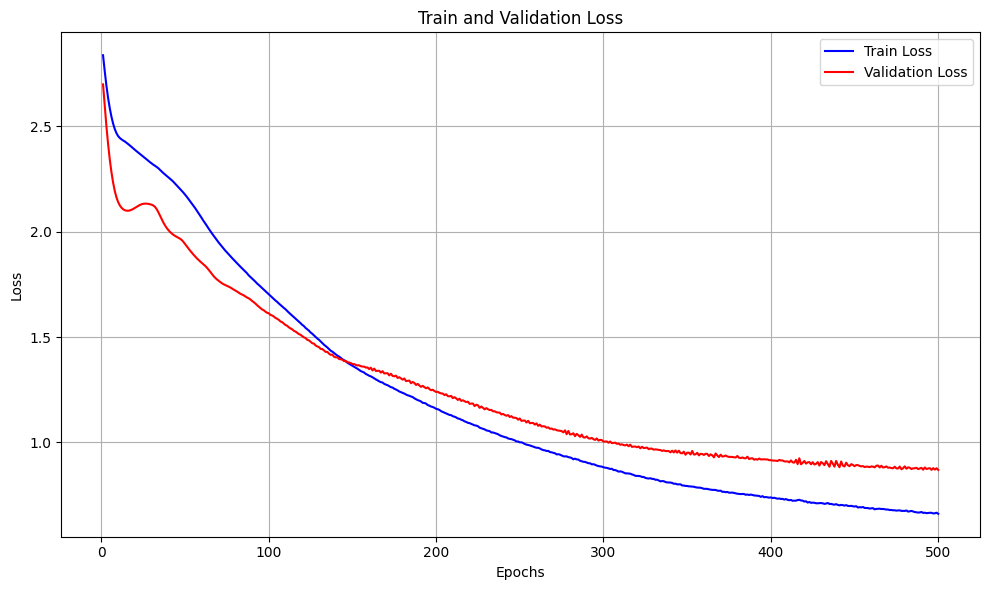

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


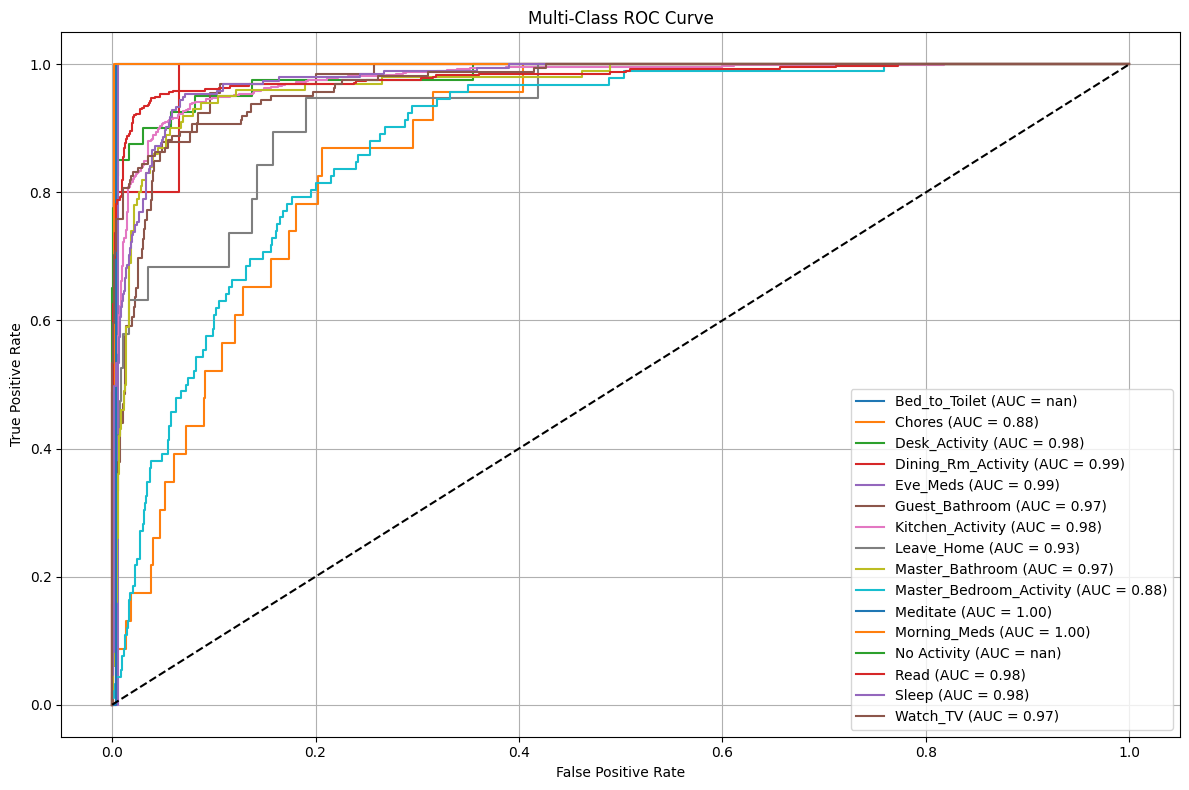

In [10]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

class TransformerGRUParallel(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, gru_hidden_sizes, num_classes, unique_sensor_dim, dropout=0.2):
        super(TransformerGRUParallel, self).__init__()

        self.sensor_embedding = nn.Embedding(num_embeddings=unique_sensor_dim, embedding_dim=ff_dim)
        self.feature_embedding = nn.Linear(d_model - 1, ff_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=ff_dim, num_heads=num_heads, dropout=dropout)

        self.gru1 = nn.GRU(input_size=ff_dim, hidden_size=gru_hidden_sizes[0], batch_first=True, num_layers=2, dropout=dropout, bidirectional=True)
        self.gru2 = nn.GRU(input_size=gru_hidden_sizes[0]*2, hidden_size=gru_hidden_sizes[1], batch_first=True, num_layers=2, dropout=dropout, bidirectional=True)
        self.gru3 = nn.GRU(input_size=gru_hidden_sizes[1]*2, hidden_size=gru_hidden_sizes[2], batch_first=True, num_layers=2, dropout=dropout, bidirectional=True)

        self.fc = nn.Linear(ff_dim + gru_hidden_sizes[2]*2, num_classes)

    def forward(self, x):
        unique_sensor_features = x[:, :, 0].long()
        other_features = x[:, :, 1:]

        unique_embedding = self.sensor_embedding(unique_sensor_features)
        other_embedding = self.feature_embedding(other_features)

        combined_embedding = unique_embedding + other_embedding

        attn_input = combined_embedding.permute(1, 0, 2)
        attn_output, _ = self.multihead_attn(attn_input, attn_input, attn_input)
        attn_output = attn_output.permute(1, 0, 2)

        gru_out, _ = self.gru1(combined_embedding)
        gru_out, _ = self.gru2(gru_out)
        gru_out, _ = self.gru3(gru_out)

        combined = torch.cat((attn_output.mean(dim=1), gru_out.mean(dim=1)), dim=1)

        output = self.fc(combined)
        return output


features_size = X_train_tensor.shape[2]
num_classes = len(np.unique(y))
unique_sensor_dim = len(np.unique(X_train_tensor[:, :, 0].cpu().numpy()))

model = TransformerGRUParallel(
    d_model=features_size,
    num_heads=8,
    ff_dim=128,
    gru_hidden_sizes=[32, 64, 128],
    num_classes=num_classes,
    unique_sensor_dim=unique_sensor_dim,
    dropout=0.1
).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

class_names = label_encoder.classes_
label_to_index = {name: idx for idx, name in enumerate(class_names)}
num_classes = len(class_names)

features_size = X_train_tensor.shape[2]
unique_sensor_dim = len(np.unique(X_train_tensor[:, :, 0].cpu().numpy()))


num_epochs = 500
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor.to(device))
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor.to(device))
        val_loss = criterion(val_outputs, y_val_tensor.to(device))
        val_losses.append(val_loss.item())

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")


def report_metrics(true, pred, title):
    print(f"\n--- {title} ---")
    print(f"Accuracy : {accuracy_score(true, pred)*100:.2f}%")
    print(f"Precision: {precision_score(true, pred, average='weighted', zero_division=1)*100:.2f}%")
    print(f"Recall   : {recall_score(true, pred, average='weighted', zero_division=1)*100:.2f}%")
    print(f"F1 Score : {f1_score(true, pred, average='weighted', zero_division=1)*100:.2f}%")
    
    cm = confusion_matrix(true, pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor.to(device)).argmax(dim=1).cpu().numpy()
    val_preds = model(X_val_tensor.to(device)).argmax(dim=1).cpu().numpy()
    test_preds = model(X_test_tensor.to(device)).argmax(dim=1).cpu().numpy()

train_labels = y_train_tensor.cpu().numpy()
val_labels = y_val_tensor.cpu().numpy()
test_labels = y_test_tensor.cpu().numpy()

report_metrics(train_labels, train_preds, "Train Data")
report_metrics(val_labels, val_preds, "Validation Data")
report_metrics(test_labels, test_preds, "Test Data")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad():
    y_probs = torch.softmax(model(X_test_tensor.to(device)), dim=1).cpu().numpy()
    y_true_bin = label_binarize(test_labels, classes=np.arange(num_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multi-Class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
